## 单细胞RNA测序数据分析：从Scanpy到VAE/CVAE完整流程

In [1]:
# ## 1. 环境准备和数据加载

import os
import sys
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# 设置Scanpy参数
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# 添加项目路径
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJ_ROOT = os.path.abspath(os.path.join(BASE_DIR, '..'))
if PROJ_ROOT not in sys.path:
    sys.path.insert(0, PROJ_ROOT)

In [3]:
# 导入项目模块
from data_processing import make_counts_training_tensors_v2
from VAE_NB.models import VAE
from VAE_NB.training import train_vae
from CVAE_NB.models import CVAE
from CVAE_NB.training import train as train_cvae


In [4]:
# 数据路径配置
DATA_PATH = 'data/GSE149614_HCC_scRNA_test_5N5T_counts.h5ad'
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# 加载原始计数数据
adata_counts = sc.read_h5ad(DATA_PATH)
print(f"📊 数据维度: {adata_counts.shape}")
print(f"📋 细胞类型: {adata_counts.obs['celltype'].value_counts()}")
print(f"🧪 样本信息: {adata_counts.obs['sample'].value_counts()}")


📊 数据维度: (42620, 25712)
📋 细胞类型: celltype
T/NK           17796
Hepatocyte     10888
Myeloid         8094
B               2540
Endothelial     2012
Fibroblast      1290
Name: count, dtype: int64
🧪 样本信息: sample
HCC08T    4833
HCC03T    4825
HCC08N    4795
HCC05N    4656
HCC06N    4465
HCC06T    4308
HCC02T    4101
HCC07N    3740
HCC04T    3501
HCC04N    3396
Name: count, dtype: int64


In [5]:
# ### 工具函数定义

def ensure_size_factors(adata):
    """确保数据包含size_factors信息"""
    if 'size_factors' in adata.obs:
        return
    X = adata.X
    if hasattr(X, 'sum'):
        totals = np.asarray(X.sum(axis=1)).reshape(-1) if not hasattr(X.sum(axis=1), 'A1') else X.sum(axis=1).A1
    else:
        totals = X.sum(axis=1)
    med = np.median(totals[totals>0]) if np.any(totals>0) else 1.0
    sf = totals/(med if med>0 else 1.0)
    sf = np.where(sf<=0, 1.0, sf).astype(np.float32)
    adata.obs['size_factors'] = sf

def standardize_latents(latents):
    """标准化潜在表示"""
    return (latents - latents.mean(axis=0)) / (latents.std(axis=0) + 1e-8)

def save_training_curves(loss_list, recon_list, kl_list, title, save_path=None):
    """绘制并保存训练损失曲线"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    epochs = range(1, len(loss_list) + 1)
    
    ax1.plot(epochs, loss_list, 'b-', linewidth=2)
    ax1.set_title(f'{title} - Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, recon_list, 'r-', linewidth=2)
    ax2.set_title(f'{title} - Reconstruction Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Reconstruction Loss')
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(epochs, kl_list, 'g-', linewidth=2)
    ax3.set_title(f'{title} - KL Divergence')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('KL Divergence')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

🔬 开始Scanpy分析流程...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
📊 选择了 2000 个高变基因
computing PCA
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)
🎯 Leiden聚类识别了 36 个簇
✅ Scanpy分析流程完成


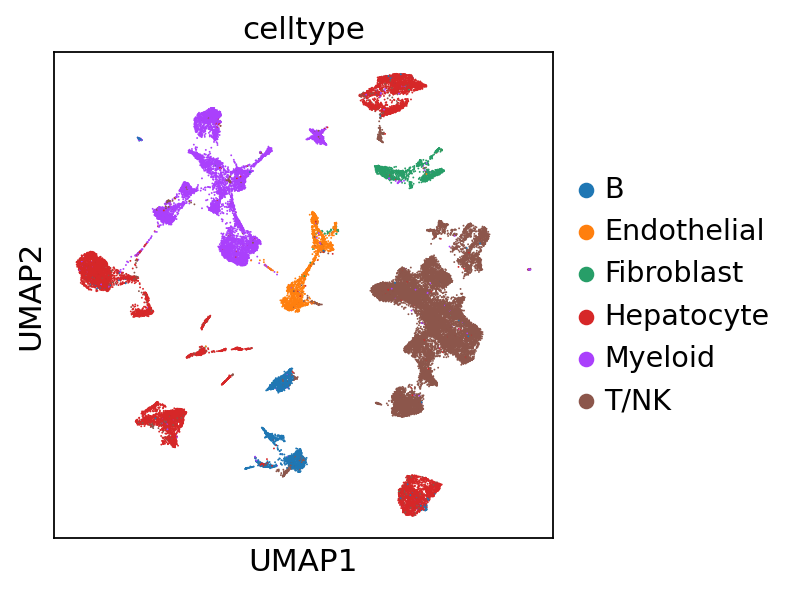

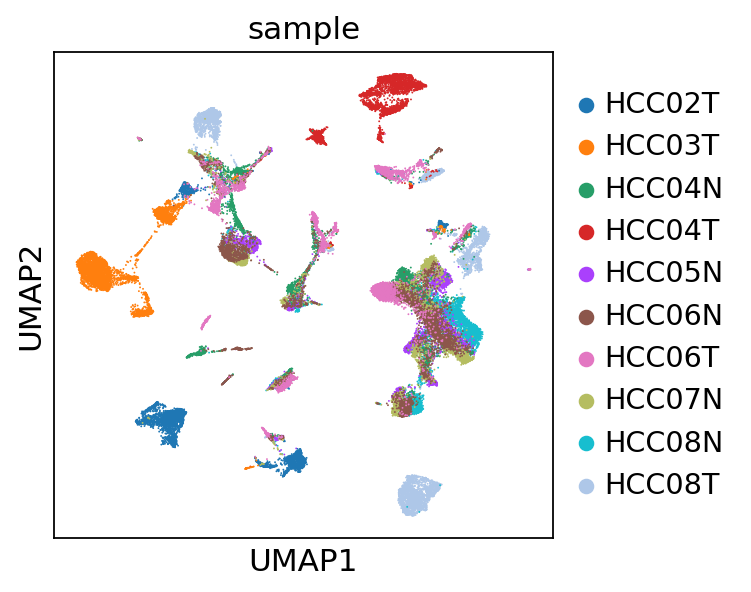

In [6]:
# ## 2. Scanpy传统分析流程

def run_scanpy_pipeline(adata_counts, n_top_genes=2000):
    """运行标准的Scanpy单细胞分析流程"""
    print("🔬 开始Scanpy分析流程...")
    
    adata = adata_counts.copy()
    ensure_size_factors(adata)
    adata.raw = adata
    
    # 标准化和对数变换
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # 高变基因选择
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    print(f"📊 选择了 {adata.var['highly_variable'].sum()} 个高变基因")
    adata = adata[:, adata.var['highly_variable']].copy()
    
    # 标准化、PCA、邻居图、UMAP
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, metric='euclidean')
    sc.tl.umap(adata, min_dist=0.2)
    
    # Leiden聚类
    try:
        sc.tl.leiden(adata, resolution=1.0)
        print(f"🎯 Leiden聚类识别了 {len(adata.obs['leiden'].unique())} 个簇")
    except Exception as e:
        print(f"⚠️ Leiden聚类失败: {e}")
    
    print("✅ Scanpy分析流程完成")
    return adata

# 运行Scanpy分析
adata_scanpy = run_scanpy_pipeline(adata_counts)

# 可视化Scanpy结果
sc.pl.umap(adata_scanpy, color='celltype', save='_scanpy_celltype.png')
sc.pl.umap(adata_scanpy, color='sample', save='_scanpy_sample.png')

2025-09-14 02:35:22,083 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


🎵 开始Harmony批次校正...


2025-09-14 02:35:26,609 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-14 02:35:26,818 - harmonypy - INFO - Iteration 1 of 10
2025-09-14 02:35:41,121 - harmonypy - INFO - Iteration 2 of 10
2025-09-14 02:35:53,407 - harmonypy - INFO - Iteration 3 of 10
2025-09-14 02:36:06,779 - harmonypy - INFO - Iteration 4 of 10
2025-09-14 02:36:18,403 - harmonypy - INFO - Iteration 5 of 10
2025-09-14 02:36:31,029 - harmonypy - INFO - Iteration 6 of 10
2025-09-14 02:36:42,572 - harmonypy - INFO - Iteration 7 of 10
2025-09-14 02:36:54,233 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:24)
✅ Harmony分析完成


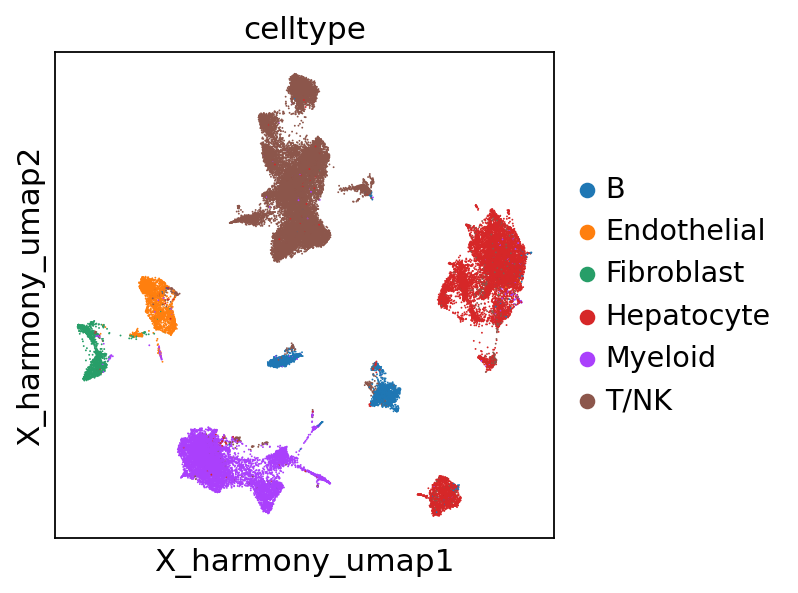

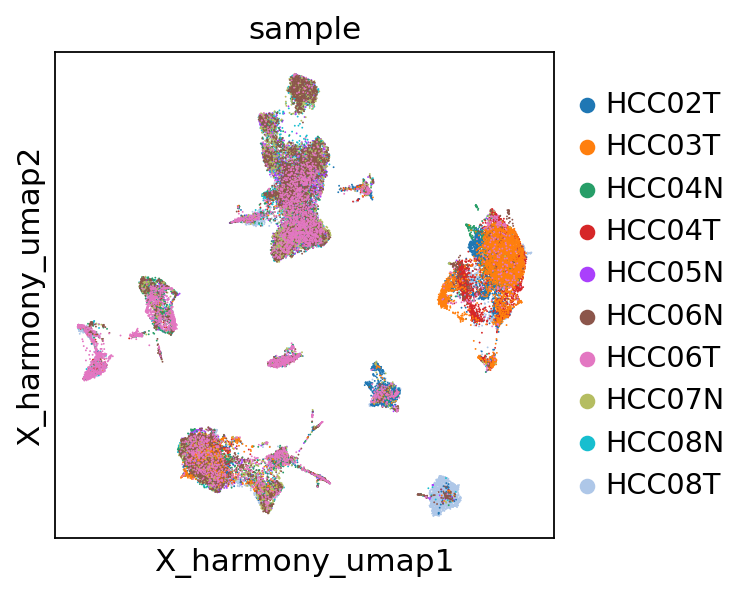

In [7]:
# ## 3. Harmony批次校正

def run_harmony_integration(adata, batch_key='sample'):
    """使用Harmony进行批次校正"""
    print("🎵 开始Harmony批次校正...")
    
    try:
        import scanpy.external as sce
        
        if batch_key not in adata.obs.columns:
            print(f"⚠️ 批次键 '{batch_key}' 不存在，跳过Harmony分析")
            return adata
        
        # Harmony整合
        sce.pp.harmony_integrate(adata, key=batch_key, basis='X_pca')
        
        # 基于Harmony结果重新计算UMAP
        sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=15, metric='euclidean')
        sc.tl.umap(adata, min_dist=0.2)
        adata.obsm['X_harmony_umap'] = adata.obsm['X_umap'].copy()
        
        # 恢复原始UMAP
        sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, metric='euclidean')
        sc.tl.umap(adata, min_dist=0.2)
        
        print("✅ Harmony分析完成")
        
    except ImportError:
        print("⚠️ 无法导入Harmony，跳过Harmony分析")
    except Exception as e:
        print(f"⚠️ Harmony分析失败: {e}")
    
    return adata

# 运行Harmony分析
adata_scanpy = run_harmony_integration(adata_scanpy)

# 可视化Harmony结果
if 'X_harmony_umap' in adata_scanpy.obsm:
    sc.pl.embedding(adata_scanpy, basis='X_harmony_umap', color='celltype', save='_harmony_celltype.png')
    sc.pl.embedding(adata_scanpy, basis='X_harmony_umap', color='sample', save='_harmony_sample.png')

🧠 开始训练VAE_NB模型...
📊 训练数据维度: torch.Size([42620, 25712])
🏗️ 模型参数数量: 54,055,712
✅ VAE_NB训练完成


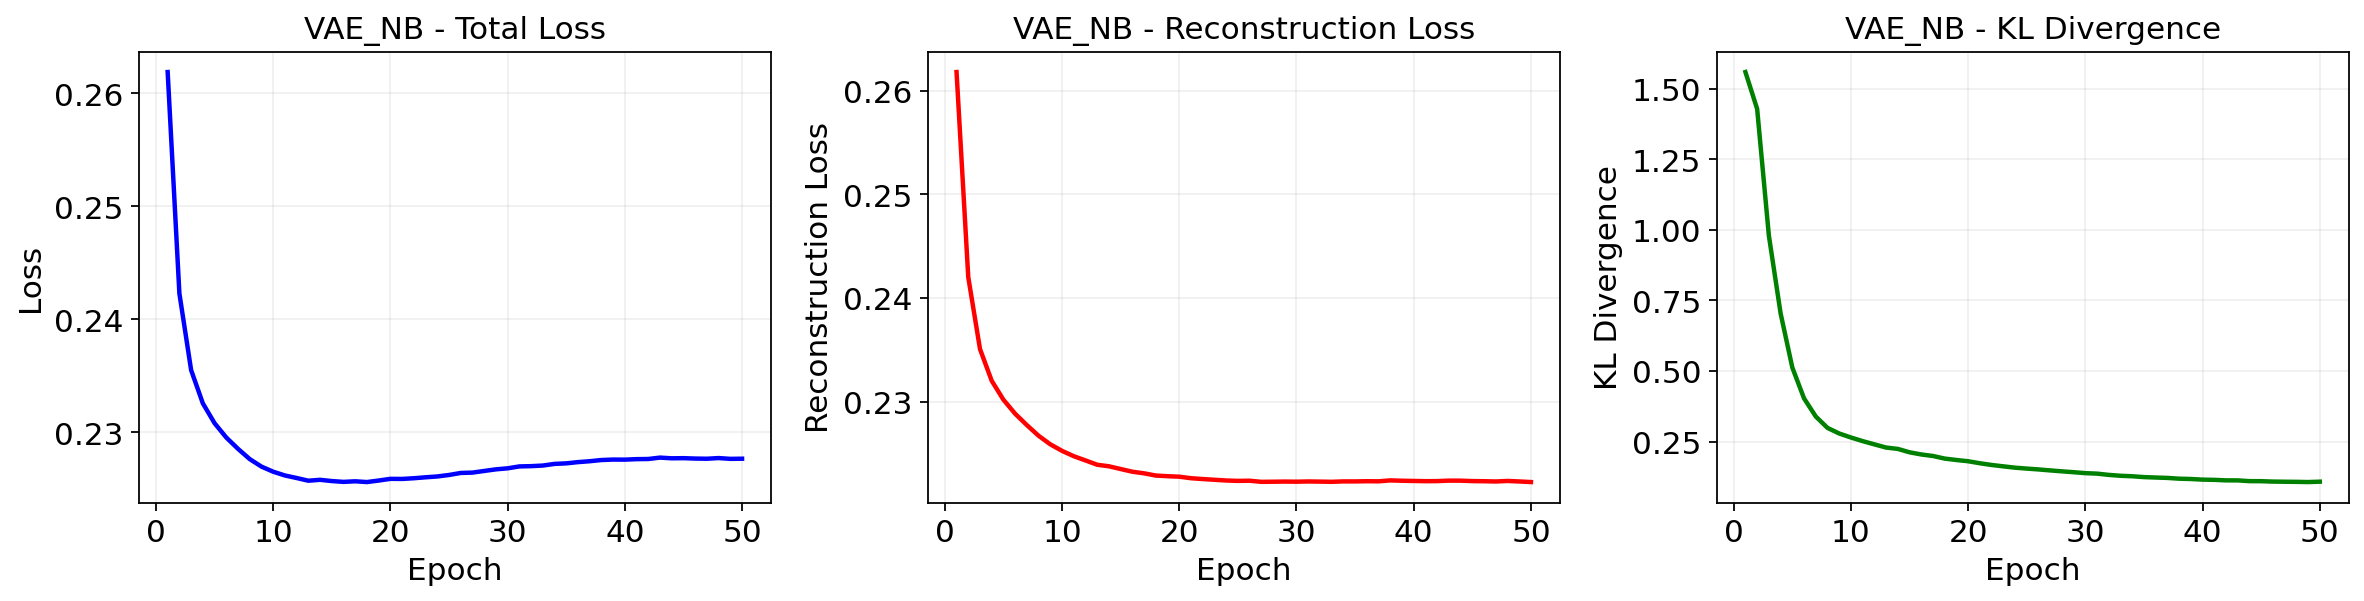

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:20)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


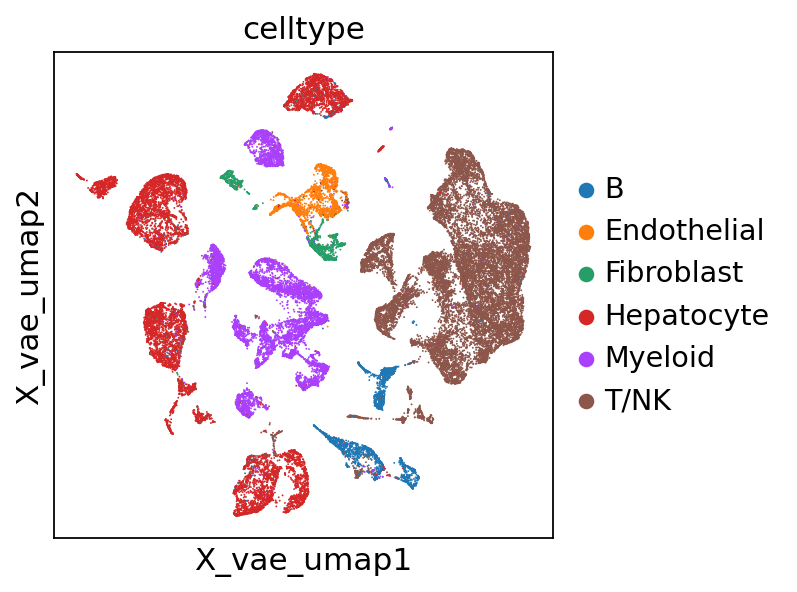

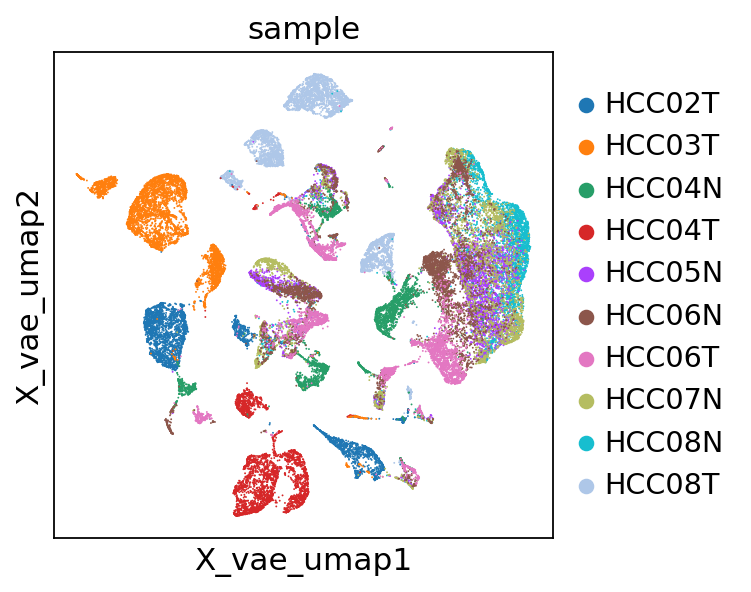

In [8]:
# ## 4. VAE_NB模型训练

def train_vae_model(adata_counts, epochs=50, batch_size=128, lr=1e-3, latent_dim=32):
    """训练VAE_NB模型"""
    print("🧠 开始训练VAE_NB模型...")
    
    # 准备训练数据
    X, y_disc, y_cont, sf, x_target, cond_dims, cont_dim = make_counts_training_tensors_v2(
        adata_counts, discrete_key='sample', cont_keys=None, use_hvgs=False, return_dims=True
    )
    
    print(f"📊 训练数据维度: {X.shape}")
    
    # 创建数据加载器
    dataset = TensorDataset(X, y_disc, y_cont, sf, x_target)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # 创建VAE模型
    vae_model = VAE(
        input_dim=X.shape[1], latent_dim=latent_dim,
        encoder_layers=[1024, 512, 256], decoder_layers=[256, 512, 1024],
        activation='gelu', norm='layernorm', dropout=0.1, recon_dist='nb'
    )
    
    print(f"🏗️ 模型参数数量: {sum(p.numel() for p in vae_model.parameters()):,}")
    
    # 训练模型
    optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr)
    loss_list, recon_list, kl_list = train_vae(
        vae_model, train_loader, optimizer, epochs, conditional=False, recon_dist='nb',
        beta_final=0.05, beta_warmup_epochs=epochs, free_bits=0.10, 
        kl_schedule='cosine', kl_period=epochs
    )
    
    # 提取潜在表示
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae_model = vae_model.to(device)
    vae_model.eval()
    
    latents_list = []
    with torch.no_grad():
        for batch in eval_loader:
            x_batch = batch[0].to(device)
            mu, _ = vae_model.encode(x_batch)
            latents_list.append(mu.cpu().numpy())
    
    latents = np.vstack(latents_list)
    latents_std = standardize_latents(latents)
    
    print("✅ VAE_NB训练完成")
    
    # 保存训练曲线
    save_training_curves(loss_list, recon_list, kl_list, 'VAE_NB', 
                         save_path=f'{RESULTS_DIR}/vae_nb_training_curves.png')
    plt.show()
    
    return latents, latents_std, {'loss': loss_list, 'recon': recon_list, 'kl': kl_list}

# 训练VAE模型
vae_latents, vae_latents_std, vae_loss_history = train_vae_model(adata_counts, epochs=50)

# 将VAE结果添加到数据中并计算UMAP
adata_scanpy.obsm['X_vae_nb'] = vae_latents
adata_scanpy.obsm['X_vae_nb_std'] = vae_latents_std

sc.pp.neighbors(adata_scanpy, use_rep='X_vae_nb_std', n_neighbors=15, metric='euclidean')
sc.tl.umap(adata_scanpy, min_dist=0.2)
adata_scanpy.obsm['X_vae_umap'] = adata_scanpy.obsm['X_umap'].copy()

# 恢复原始邻居图
sc.pp.neighbors(adata_scanpy, use_rep='X_pca', n_neighbors=15, metric='euclidean')
sc.tl.umap(adata_scanpy, min_dist=0.2)

# 可视化VAE结果
sc.pl.embedding(adata_scanpy, basis='X_vae_umap', color='celltype', save='_vae_celltype.png')
sc.pl.embedding(adata_scanpy, basis='X_vae_umap', color='sample', save='_vae_sample.png')

🧠 开始训练CVAE_NB模型...
📊 训练数据维度: torch.Size([42620, 25712])
🏷️ 条件维度: [10], 0
🏗️ 模型参数数量: 39,862,756
✅ CVAE_NB训练完成


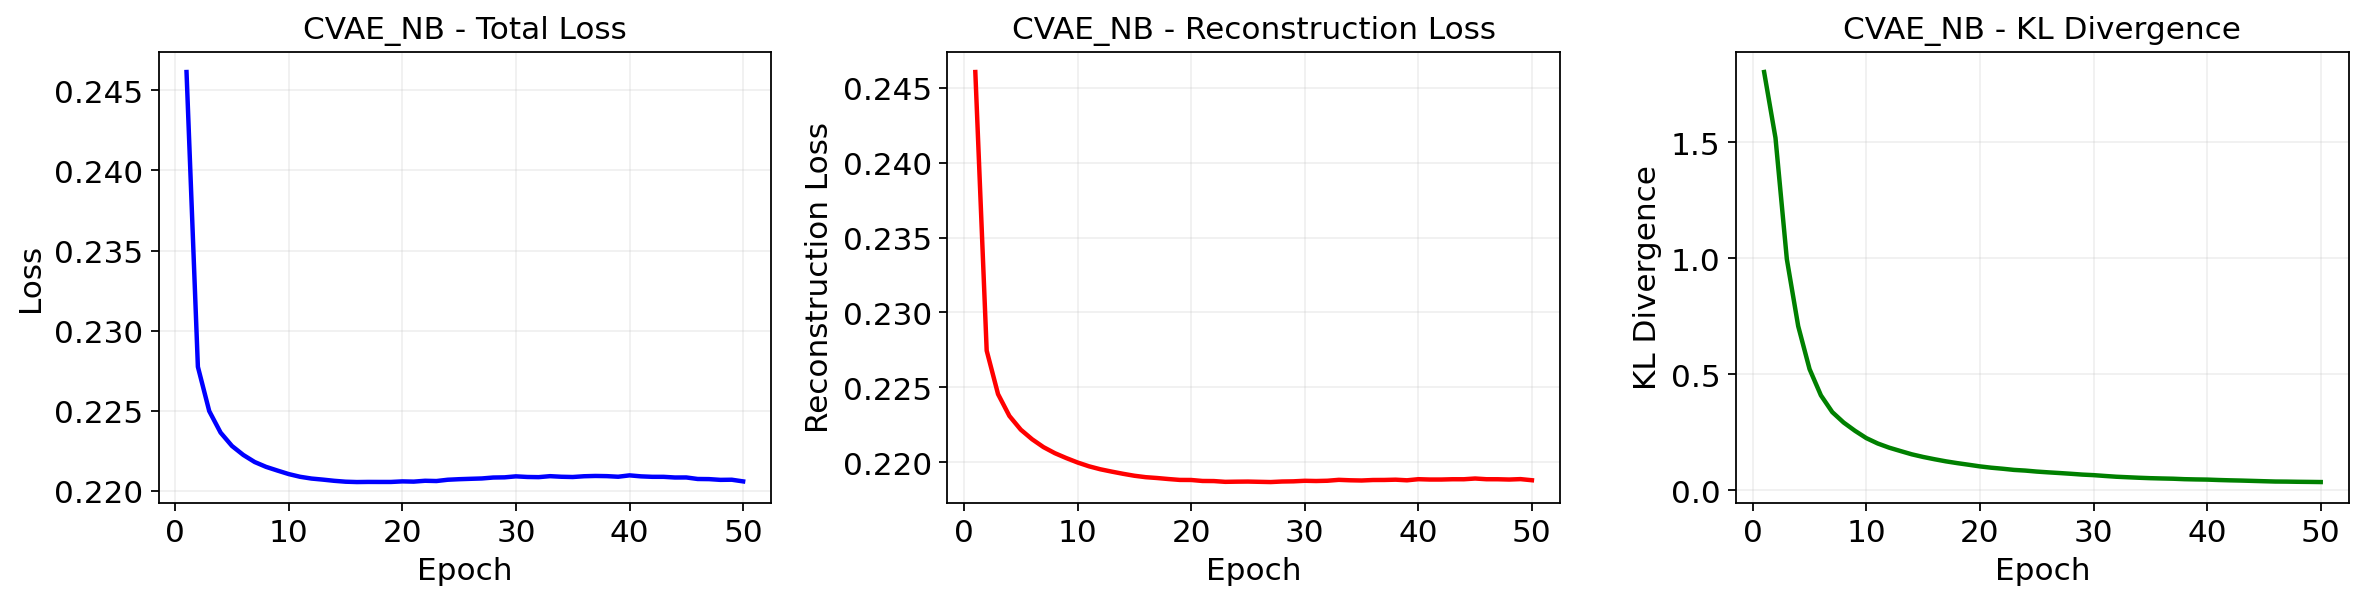

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)


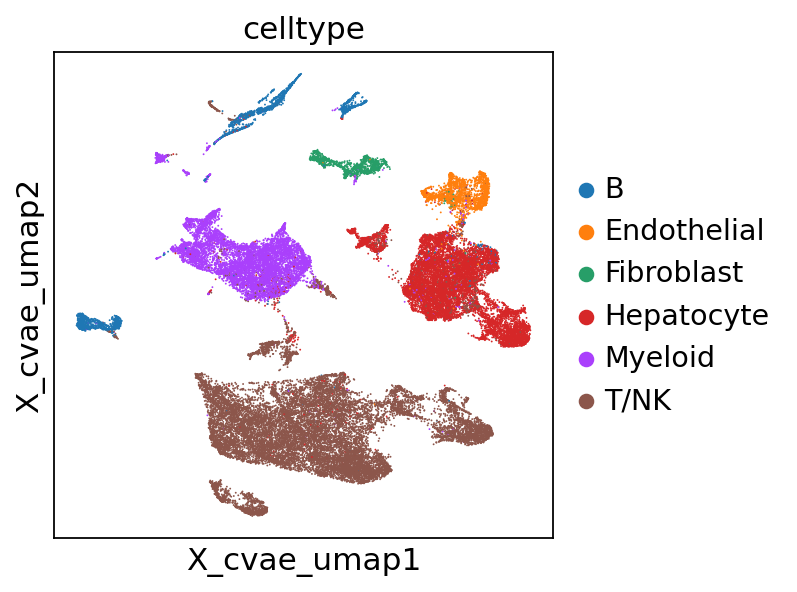

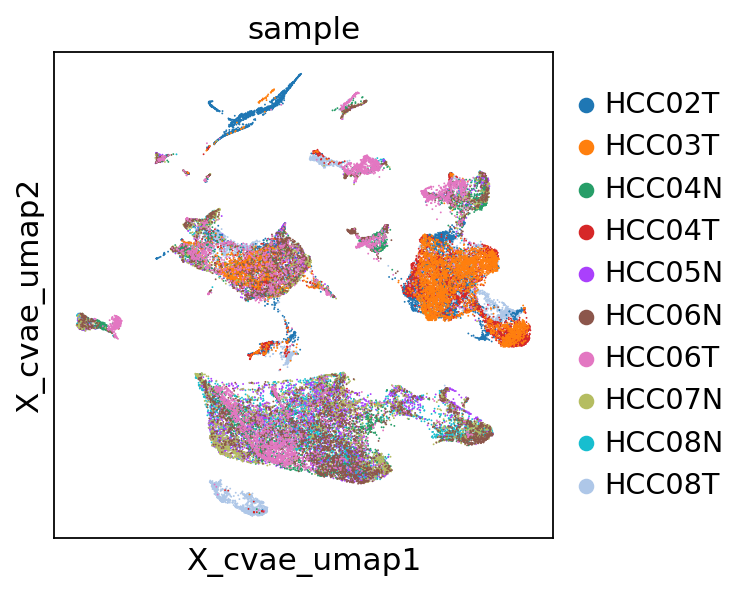

In [16]:
# ## 5. CVAE_NB模型训练

def train_cvae_model(adata_counts, epochs=100, batch_size=128, lr=1e-3, latent_dim=50):
    """训练CVAE_NB模型（条件化批次信息）"""
    print("🧠 开始训练CVAE_NB模型...")
    
    # 准备训练数据
    X, y_disc, y_cont, sf, x_target, cond_dims, cont_dim = make_counts_training_tensors_v2(
        adata_counts, discrete_key='sample', cont_keys=None, use_hvgs=False, return_dims=True
    )
    
    print(f"📊 训练数据维度: {X.shape}")
    print(f"🏷️ 条件维度: {cond_dims}, {cont_dim}")
    
    # 创建数据加载器
    dataset = TensorDataset(X, y_disc, y_cont, sf, x_target)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # 创建CVAE模型
    cvae_model = CVAE(
        input_dim=X.shape[1],
        cond_dim=cond_dims if isinstance(cond_dims, (list, tuple)) else int(cond_dims),
        cont_dim=int(cont_dim), latent_dim=latent_dim,
        encoder_layers=[512, 256], decoder_layers=[256, 512],
        activation='gelu', norm='layernorm', dropout=0.1, recon_dist='nb', cond_in_encoder=True
    )
    
    print(f"🏗️ 模型参数数量: {sum(p.numel() for p in cvae_model.parameters()):,}")
    
    # 训练模型
    optimizer = torch.optim.Adam(cvae_model.parameters(), lr=lr)
    loss_list, recon_list, kl_list = train_cvae(
        cvae_model, train_loader, optimizer, epochs, conditional=True, recon_dist='nb',
        beta_final=0.05, beta_warmup_epochs=epochs, free_bits=0.10, 
        kl_schedule='cosine', kl_period=epochs
    )
    
    # 提取潜在表示
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cvae_model = cvae_model.to(device)
    cvae_model.eval()
    
    latents_list = []
    with torch.no_grad():
        for batch in eval_loader:
            x_batch = batch[0].to(device)
            y_disc_batch = batch[1].to(device)
            y_cont_batch = batch[2].to(device)
            mu, _ = cvae_model.encode(x_batch, y_disc_batch, y_cont_batch)
            latents_list.append(mu.cpu().numpy())
    
    latents = np.vstack(latents_list)
    latents_std = standardize_latents(latents)
    
    print("✅ CVAE_NB训练完成")
    
    # 保存训练曲线
    save_training_curves(loss_list, recon_list, kl_list, 'CVAE_NB',
                         save_path=f'{RESULTS_DIR}/cvae_nb_training_curves.png')
    plt.show()
    
    return latents, latents_std, {'loss': loss_list, 'recon': recon_list, 'kl': kl_list}

# 训练CVAE模型
cvae_latents, cvae_latents_std, cvae_loss_history = train_cvae_model(adata_counts, epochs=50)

# 将CVAE结果添加到数据中并计算UMAP
adata_scanpy.obsm['X_cvae_nb'] = cvae_latents
adata_scanpy.obsm['X_cvae_nb_std'] = cvae_latents_std

sc.pp.neighbors(adata_scanpy, use_rep='X_cvae_nb_std', n_neighbors=15, metric='euclidean')
sc.tl.umap(adata_scanpy, min_dist=0.2)
adata_scanpy.obsm['X_cvae_umap'] = adata_scanpy.obsm['X_umap'].copy()

# 恢复原始邻居图
sc.pp.neighbors(adata_scanpy, use_rep='X_pca', n_neighbors=15, metric='euclidean')
sc.tl.umap(adata_scanpy, min_dist=0.2)

# 可视化CVAE结果
sc.pl.embedding(adata_scanpy, basis='X_cvae_umap', color='celltype', save='_cvae_celltype.png')
sc.pl.embedding(adata_scanpy, basis='X_cvae_umap', color='sample', save='_cvae_sample.png')

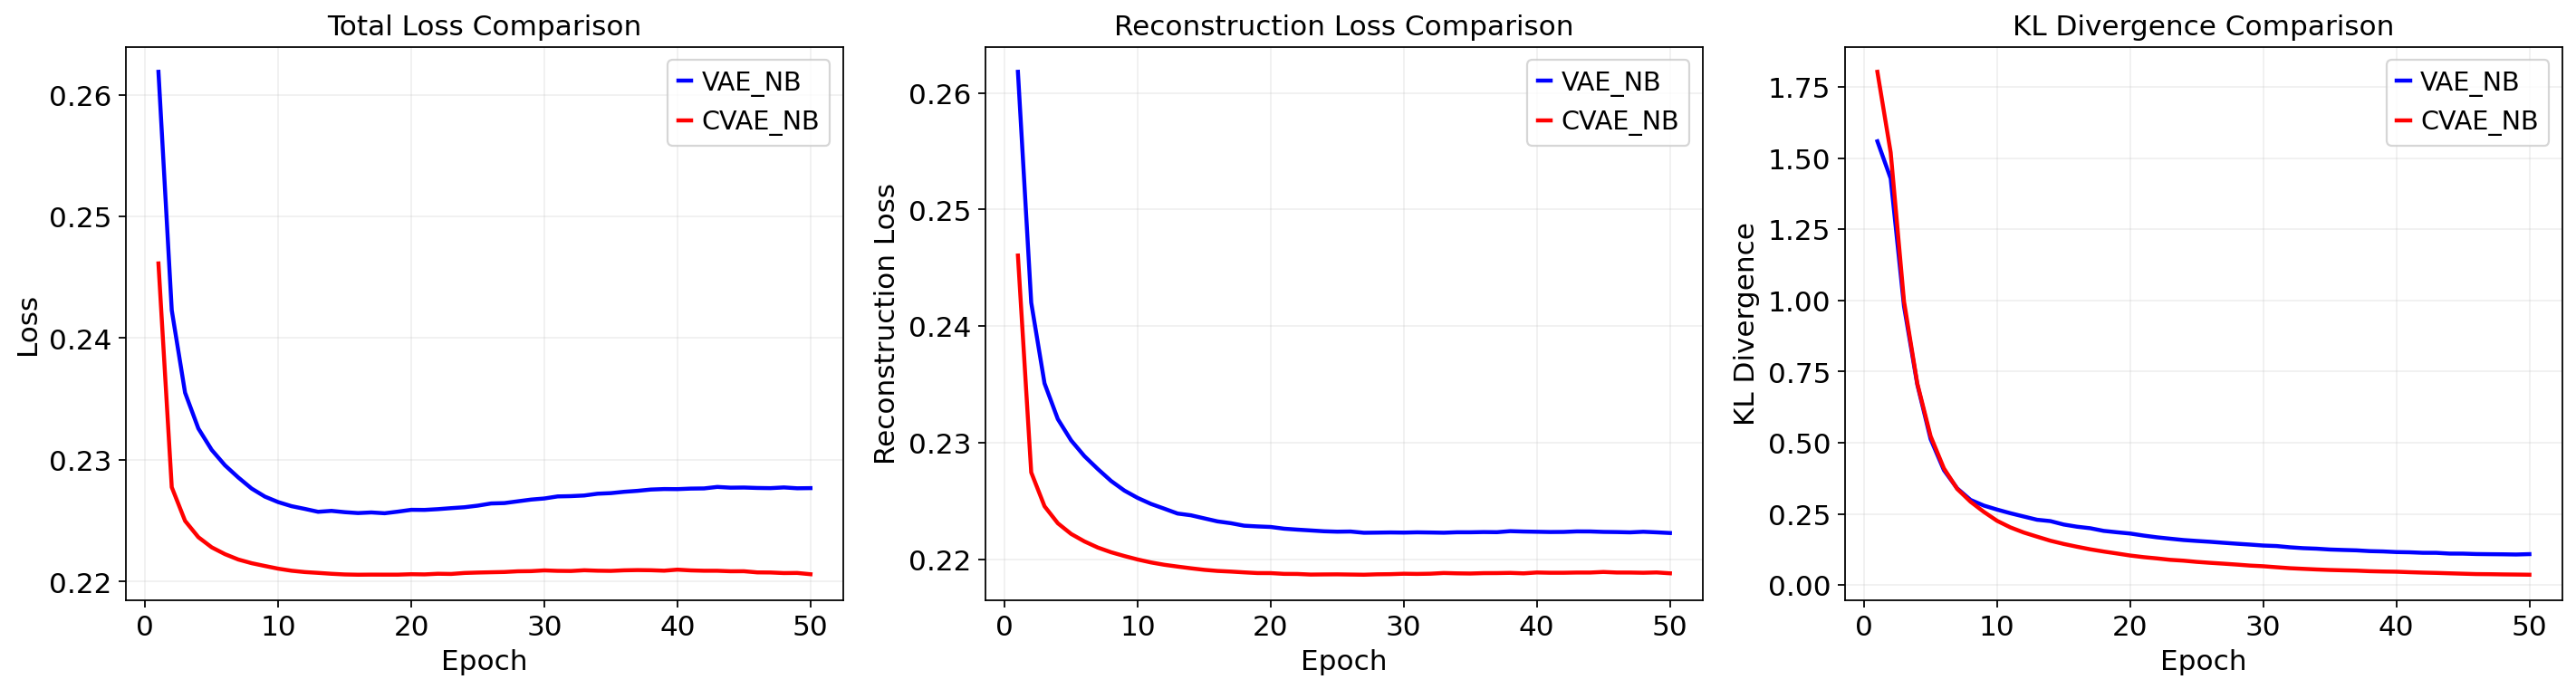

In [17]:
# ## 6. 结果对比和可视化

# ### 训练损失对比
if 'vae_loss_history' in locals() and 'cvae_loss_history' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs_vae = range(1, len(vae_loss_history['loss']) + 1)
    epochs_cvae = range(1, len(cvae_loss_history['loss']) + 1)
    
    # 总损失对比
    axes[0].plot(epochs_vae, vae_loss_history['loss'], 'b-', linewidth=2, label='VAE_NB')
    axes[0].plot(epochs_cvae, cvae_loss_history['loss'], 'r-', linewidth=2, label='CVAE_NB')
    axes[0].set_title('Total Loss Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 重构损失对比
    axes[1].plot(epochs_vae, vae_loss_history['recon'], 'b-', linewidth=2, label='VAE_NB')
    axes[1].plot(epochs_cvae, cvae_loss_history['recon'], 'r-', linewidth=2, label='CVAE_NB')
    axes[1].set_title('Reconstruction Loss Comparison')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Reconstruction Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # KL散度对比
    axes[2].plot(epochs_vae, vae_loss_history['kl'], 'b-', linewidth=2, label='VAE_NB')
    axes[2].plot(epochs_cvae, cvae_loss_history['kl'], 'r-', linewidth=2, label='CVAE_NB')
    axes[2].set_title('KL Divergence Comparison')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KL Divergence')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/training_loss_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()